In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import sys

# from degree_days import dds
from tensor_custom_core import *
sys.path.insert(0, '../../aaai18/code/')
import datetime
from sklearn.model_selection import train_test_split, KFold
from common import *
from create_matrix import *
from sklearn.metrics.pairwise import cosine_similarity

import random
from sklearn.cluster import KMeans

appliance_index = {appliance: APPLIANCES_ORDER.index(appliance) for appliance in APPLIANCES_ORDER}

APPLIANCES = ['fridge', 'hvac', 'wm', 'mw', 'oven', 'dw']
region = "Austin"
year = 2014

import os

def un_normalize(x, maximum, minimum):
    return (maximum - minimum) * x + minimum

In [22]:
df, dfc, tensor, static_feature = create_region_df_dfc_static('Austin', 2014, 1, 13)
L = get_L(static_feature)
case = 2
a = 3
b = 3
weight_matrix = np.ones(tensor.shape)
T_constant = np.ones(12).reshape(-1, 1)
tensor_copy = tensor.copy()
H, A, T, Hs, As, Ts, HATs, costs = learn_HAT_adagrad_graph(case, tensor_copy,
                                                            L,
                                                          a,
                                                          b, weight_matrix,
                                                          num_iter=3000,
                                                          lr=0.1, dis=True,
                                                          lam=0,
                                                          T_known=T_constant)

498.390915785
140.09512203
101.379737927
88.5219212457
83.0967795185
79.9035478544


In [23]:
from sklearn.cluster import KMeans
# for home factors learnt from aggregate readings
X = H.copy()
X = X/np.max(X)
cluster = KMeans(n_clusters=10, random_state=0).fit_predict(X)
x1, x2 = (-np.var(X, axis=0)).argsort()[:2]

x1=2 
x2=0

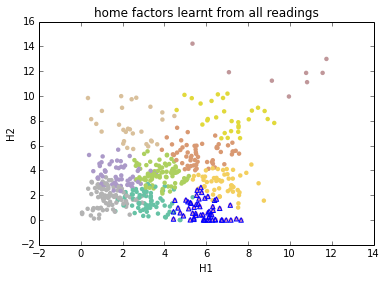

In [100]:
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D

start = len(tensor)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(X[:, x1], X[:, x2], c = cluster, cmap='Set2', lw=0)
plt.xlabel("H1")
plt.ylabel("H2")
plt.title("home factors learnt from all readings")


validate_cluster_id = 9
validate_cluster_idx = [i for i, j in enumerate(cluster) if j == validate_cluster_id]
test_cluster_id = 4
test_cluster_idx = [i for i, j in enumerate(cluster) if j == test_cluster_id]

ax.scatter(X[test_cluster_idx, x1], X[test_cluster_idx, x2], color='blue', marker='^', facecolors='none')



In [101]:
import random
random.seed(10)
random.shuffle(test_cluster_idx)
random.shuffle(validate_cluster_idx)
test_idx = test_cluster_idx[:6]
validate_same_idx = test_cluster_idx[6:12]
validate_diff_idx = validate_cluster_idx[:6]

test_validate_idx = np.r_[test_idx, validate_idx]
train_idx = list(set(list(range(533))) - set(test_validate_idx))

In [102]:
train_ix = df.index[train_idx]
test_ix = df.index[test_idx]
validate_same_ix = df.index[validate_same_idx]
validate_diff_ix = df.index[validate_diff_idx]


idx = np.r_[test_ix, validate_ix, train_ix]
df_t = df.loc[idx]
tensor = get_tensor(df_t, 1, 13)
L_inner = L[np.ix_(np.r_[test_validate_idx, train_idx], np.r_[test_validate_idx, train_idx])]

In [104]:
test_ix = [8589, 499, 2365, 1202, 9295, 9939]
validate_same_ix = [7117, 6412, 5568, 7951, 4135, 484]
validate_diff_ix = [1714, 2233, 7900, 9121, 2158, 7641]

In [122]:
import pickle
pred = {}
pred_validation = {}
H = {}
A = {}
T = {}
weight_matrices = {}
for tv_type in ['same', 'diff']:
    pred[tv_type] = {}
    pred_validation[tv_type] = {}
    H[tv_type] = {}
    A[tv_type] = {}
    T[tv_type] = {}
    weight_matrices[tv_type] = {}
    for choice in ['max', 'min']:

        pred[tv_type][choice] = pickle.load(open("./results/pred_{}_{}.pkl".format(choice, tv_type)))
        pred_validation[tv_type][choice] = pickle.load(open("./results/pred_validation_{}_{}.pkl".format(choice, tv_type)))
        H[tv_type][choice] = pickle.load(open("./results/H_{}_{}.pkl".format(choice, tv_type)))
        A[tv_type][choice] = pickle.load(open("./results/A_{}_{}.pkl".format(choice, tv_type)))
        T[tv_type][choice] = pickle.load(open("./results/T_{}_{}.pkl".format(choice, tv_type)))
        weight_matrices[tv_type][choice] = pickle.load(open("./results/weight_matrices_{}_{}.pkl".format(choice, tv_type)))

In [124]:
out_v = {}
for tv_type in ['diff']:
    out_v[tv_type] = {}
    for choice in ['max']:
        out_v[tv_type][choice] = {}
        for iteration in range(num_iterations):
            print tv_type, choice, iteration
            out_v[tv_type][choice][iteration] = {}
            for appliance in APPLIANCES_ORDER[1:]:
                if tv_type == 'same':
                    s = pd.concat(pred_validation[tv_type][choice][iteration][appliance]).loc[validate_same_ix]
                else: 
                    s = pd.concat(pred_validation[tv_type][choice][iteration][appliance]).loc[validate_diff_ix]
                if appliance=="hvac":
                    out_v[tv_type][choice][iteration][appliance] = compute_rmse_fraction(appliance,s[range(4, 10)], 'Austin')[2]
                else:   
                    out_v[tv_type][choice][iteration][appliance] = compute_rmse_fraction(appliance, s, 'Austin')[2]

diff max 0
diff max 1
diff max 2
diff max 3
diff max 4
diff max 5
diff max 6
diff max 7
diff max 8
diff max 9
diff max 10
diff max 11
diff max 12
diff max 13
diff max 14
diff max 15
diff max 16
diff max 17
diff max 18
diff max 19


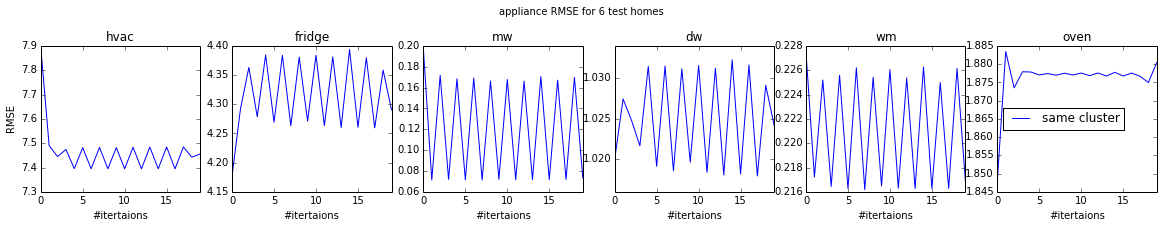

In [126]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(20,3))
ax = axes.flatten()
count = 0
mean_out_v = pd.DataFrame(out_v['diff']['max'])
       
for appliance in APPLIANCES_ORDER[1:]:
#     mean_out_v['same']['max'].T[appliance].plot(ax = ax[count], title=appliance)
    mean_out_v.T[appliance].plot(ax = ax[count], title=appliance)
#     mean_out_v['diff']['max'].T[appliance].plot(ax = ax[count], title=appliance)
#     mean_out_v['diff']['min'].T[appliance].plot(ax = ax[count], title=appliance)
    
    ax[count].set_xlabel("#itertaions")
    count += 1
ax[0].set_ylabel("RMSE")
ax[count-1].legend(['same cluster', 'different cluster'], loc='center left')
plt.suptitle("appliance RMSE for 6 validation homes")
fig.subplots_adjust(top=0.8)
# plt.savefig("appliance-RMSE_test_same_diff.pdf", format='pdf')

In [112]:
out_v = {}
for tv_type in ['same', 'diff']:
    out_v[tv_type] = {}
    for choice in ['max', 'min']:
        out_v[tv_type][choice] = {}
        for iteration in range(num_iterations):
            print tv_type, choice, iteration
            out_v[tv_type][choice][iteration] = {}
            for appliance in APPLIANCES_ORDER[1:]:
                if tv_type == 'same':
                    s = pd.concat(pred[tv_type][choice][iteration][appliance]).loc[test_ix]
                else: 
                    s = pd.concat(pred[tv_type][choice][iteration][appliance]).loc[test_ix]
                if appliance=="hvac":
                    out_v[tv_type][choice][iteration][appliance] = compute_rmse_fraction(appliance,s[range(4, 10)], 'Austin')[2]
                else:   
                    out_v[tv_type][choice][iteration][appliance] = compute_rmse_fraction(appliance, s, 'Austin')[2]

same max 0
same max 1
same max 2
same max 3
same max 4
same max 5
same max 6
same max 7
same max 8
same max 9
same max 10
same max 11
same max 12
same max 13
same max 14
same max 15
same max 16
same max 17
same max 18
same max 19
same min 0
same min 1
same min 2
same min 3
same min 4
same min 5
same min 6
same min 7
same min 8
same min 9
same min 10
same min 11
same min 12
same min 13
same min 14
same min 15
same min 16
same min 17
same min 18
same min 19
diff max 0
diff max 1
diff max 2
diff max 3
diff max 4
diff max 5
diff max 6
diff max 7
diff max 8
diff max 9
diff max 10
diff max 11
diff max 12
diff max 13
diff max 14
diff max 15
diff max 16
diff max 17
diff max 18
diff max 19
diff min 0
diff min 1
diff min 2
diff min 3
diff min 4
diff min 5
diff min 6
diff min 7
diff min 8
diff min 9
diff min 10
diff min 11
diff min 12
diff min 13
diff min 14
diff min 15
diff min 16
diff min 17
diff min 18
diff min 19


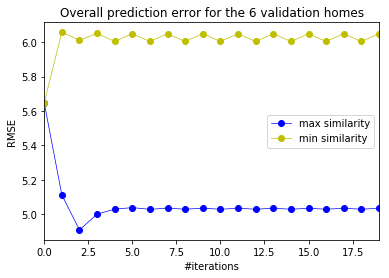

In [87]:
fig, ax = plt.subplots()
error_v = {}
error_v['max'] = (mean_out_v['max'].T*pd.Series(contri['Austin'])).sum(axis=1)
error_v['max'].plot(label='all', marker='o', ax=ax, linewidth=0.7,  color=['b'])
error_v['min'] = (mean_out_v['min'].T*pd.Series(contri['Austin'])).sum(axis=1)
error_v['min'].plot(label='all', marker='o', ax=ax, linewidth=0.7,  color=['y'])
ax.set_xlabel("#iterations")
ax.set_ylabel("RMSE")
ax.set_title("Overall prediction error for the 6 validation homes")
ax.legend(['max similarity', 'min similarity'])
plt.savefig("overall-RMSE_validate.pdf", format='pdf')

KeyError: 'min'

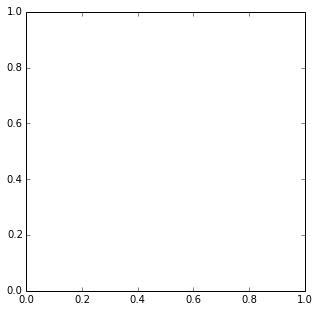

In [117]:
# fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5, 50))
fig, ax = plt.subplots(figsize=(5,5))
choice = "min"
for iteration in [6]:
    X = H[choice][iteration]
    cluster = KMeans(n_clusters=10, random_state=0).fit_predict(X)
    x1, x2 = (-np.var(X, axis=0)).argsort()[:2]
#     x1 = 2
#     x2 = 0
    
    train_sim = weight_matrices[choice][iteration][:].mean(axis=1).mean(axis=1)
    ax.scatter(X[(num_test+num_validate):, x1], X[(num_test+num_validate):, x2], c = train_sim, cmap='Blues', lw=0)
    ax.scatter(X[:num_test, x1], X[:num_test, x2], color='black', marker='o', facecolors='none')
    ax.scatter(X[num_test:(num_test+num_validate), x1], X[num_test:(num_test+num_validate), x2], color='red', marker='^', facecolors='none')
    plt.xlabel("H1")
    plt.ylabel("H2")
    ax.set_title("iteration {}". format(iteration))
    
    plt.savefig("weight_iteration_6_{}.pdf".format(choice), format='pdf')
#     axes[iteration/2].legend(loc="center left", bbox_to_anchor=(1, 0.5), title='c_id, weight')
#     plt.title('iteration {}'.format(iteration))
#     plt.title("home factors learnt from aggregate readings")

### test homes

In [49]:
out = {}
for choice in ['max', 'min']:
    out[choice] = {}
    for iteration in range(num_iterations):
        out[choice][iteration] = {}
        for appliance in APPLIANCES_ORDER[1:]:
            s = pd.concat(pred[choice][iteration][appliance]).loc[test_ix]
            if appliance=="hvac":
                out[choice][iteration][appliance] = compute_rmse_fraction(appliance,s[range(4, 10)], 'Austin')[2]
            else:   
                out[choice][iteration][appliance] = compute_rmse_fraction(appliance, s, 'Austin')[2]

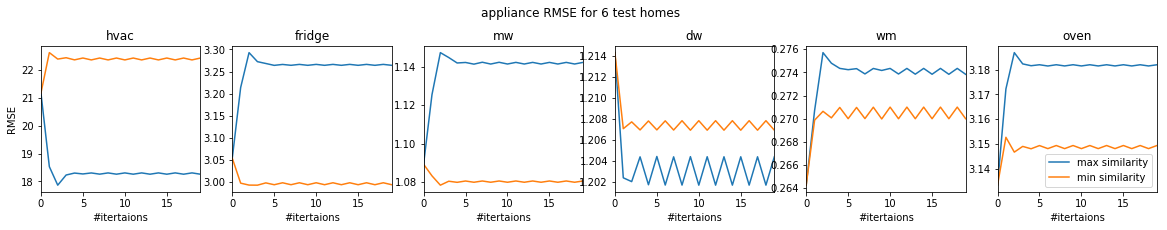

In [103]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(20,3))
ax = axes.flatten()
count = 0
mean_out = {}
mean_out['min'] = pd.DataFrame(out['min'])
mean_out['max'] = pd.DataFrame(out['max'])

for appliance in APPLIANCES_ORDER[1:]:
    mean_out['max'].T[appliance].plot(ax = ax[count], title=appliance)
    mean_out['min'].T[appliance].plot(ax = ax[count], title=appliance)
    ax[count].set_xlabel("#itertaions")
    count += 1
ax[0].set_ylabel("RMSE")
ax[count-1].legend(['max similarity', 'min similarity'])
plt.suptitle("appliance RMSE for 6 test homes")
fig.subplots_adjust(top=0.8)
plt.savefig("appliance-RMSE_test.pdf", format='pdf')

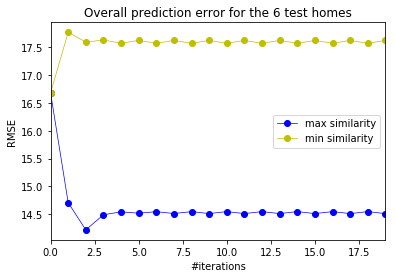

In [102]:
fig, ax = plt.subplots()
error['max'] = (mean_out['max'].T*pd.Series(contri['Austin'])).sum(axis=1)
error['max'].plot(label='all', marker='o', ax=ax, linewidth=0.7,  color=['b'])
error['min'] = (mean_out['min'].T*pd.Series(contri['Austin'])).sum(axis=1)
error['min'].plot(label='all', marker='o', ax=ax, linewidth=0.7,  color=['y'])
ax.set_xlabel("#iterations")
ax.set_ylabel("RMSE")
ax.set_title("Overall prediction error for the 6 test homes")
ax.legend(['max similarity', 'min similarity'])
plt.savefig("overall-RMSE_test.pdf", format='pdf')

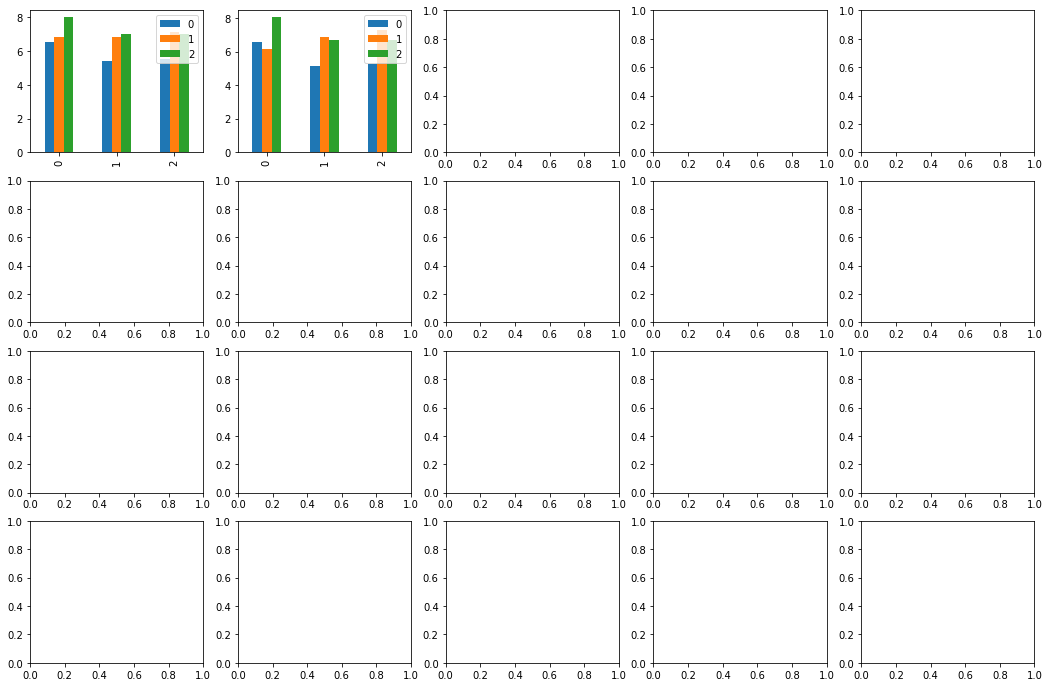

In [101]:
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(18,12))


pd.DataFrame(A['max'][2][0]).plot(ax=axes[0][0], kind='bar')
pd.DataFrame(A['min'][2][0]).plot(ax=axes[0][1], kind='bar')


In [26]:
for iteration in [1]:
    X = H[iteration]
    cluster = KMeans(n_clusters=10, random_state=0).fit_predict(X)
    train_cluster = cluster[(num_test + num_validate):]
    train_sim = weight_matrices[iteration][:].mean(axis=1).mean(axis=1)
    sim_df = pd.DataFrame(np.c_[train_cluster, train_sim], index=train_ix)
#     print sim_df
    for i in set(cluster):
        print i
        sub_cluster = sim_df.loc[sim_df[0] == i]
#         print sub_cluster[1]
        print sub_cluster[1].mean(axis=0)
    

0
0.720437494274
1
0.0135169107494
2
0.85064710518
3
0.782826517102
4
0.586187154995
5
0.968014577588
6
0.824718495544
7
0.919507619139
8
0.529737241121
9
0.349787779521


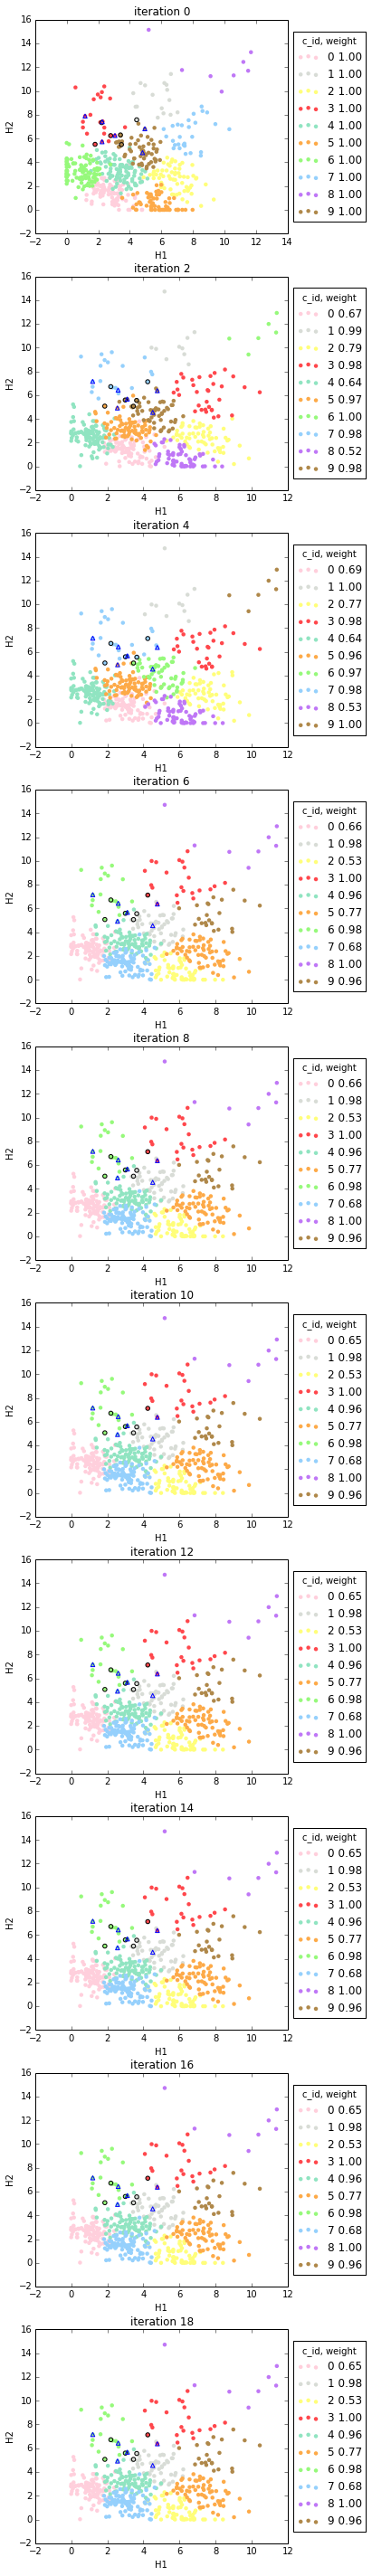

In [316]:
fig, axes = plt.subplots(nrows=10, ncols=1, figsize=(5, 50))

colors = ['#ffcfdc', '#d8dcd6', '#fffe7a', '#ff474c', '#90e4c1', '#fdaa48', '#96f97b', '#95d0fc', '#bf77f6', '#af884a']
for iteration in range(0, num_iterations, 2):
    X = H[iteration]
    cluster = KMeans(n_clusters=10, random_state=0).fit_predict(X)
    x1, x2 = (-np.var(X, axis=0)).argsort()[:2]
    x1 = 2
    x2 = 0
    
    train_cluster = cluster[(num_test + num_validate):]
    train_sim = weight_matrices[iteration][:].mean(axis=1).mean(axis=1)
    sim_df = pd.DataFrame(np.c_[train_cluster, train_sim], index=train_ix)
    
    for c_id in set(cluster):
        
        sub_cluster = sim_df.loc[sim_df[0] == c_id]
        mean_sim = format(sub_cluster[1].mean(axis=0), '.2f')
        
        index = [i for i,j in enumerate(cluster) if j == c_id]
        axes[iteration/2].scatter(X[index, x1], X[index, x2], c = colors[c_id], lw=0, label="{} {}".format(c_id, mean_sim))
    axes[iteration/2].scatter(X[:num_test, x1], X[:num_test, x2], color='black', marker='o', facecolors='none')
    axes[iteration/2].scatter(X[num_test:(num_test+num_validate), x1], X[num_test:(num_test+num_validate), x2], color='blue', marker='^', facecolors='none')
    axes[iteration/2].set_xlabel("H1")
    axes[iteration/2].set_ylabel("H2")
    axes[iteration/2].set_title("iteration {}". format(iteration))
    axes[iteration/2].legend(loc="center left", bbox_to_anchor=(1, 0.5), title='c_id, weight')
#     plt.title('iteration {}'.format(iteration))
#     plt.title("home factors learnt from aggregate readings")

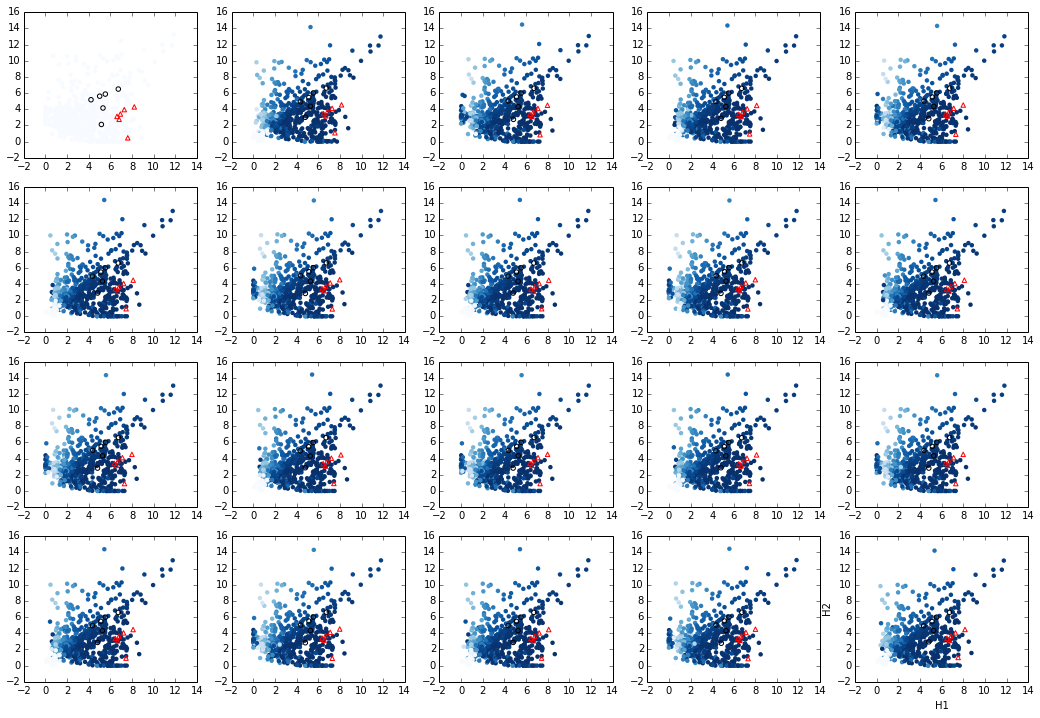

In [44]:
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(18,12))

choice = 'max'
for iteration in range(num_iterations):
    X = H['diff'][choice][iteration]
    cluster = KMeans(n_clusters=10, random_state=0).fit_predict(X)
    x1, x2 = (-np.var(X, axis=0)).argsort()[:2]
    x1 = 2
    x2 = 0
    
    train_sim = weight_matrices['diff'][choice][iteration][:].mean(axis=1).mean(axis=1)
    axes[iteration/5][iteration%5].scatter(X[(num_test+num_validate):, x1], X[(num_test+num_validate):, x2], c = train_sim, cmap='Blues', lw=0)
    axes[iteration/5][iteration%5].scatter(X[:num_test, x1], X[:num_test, x2], color='black', marker='o', facecolors='none')
    axes[iteration/5][iteration%5].scatter(X[num_test:(num_test+num_validate), x1], X[num_test:(num_test+num_validate), x2], color='red', marker='^', facecolors='none')
    plt.xlabel("H1")
    plt.ylabel("H2")
#     plt.title('iteration {}'.format(iteration))
#     plt.title("home factors learnt from aggregate readings")